In [176]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
from sklearn.decomposition import PCA
import numpy as np
import datetime
import os

from tensorflow.python.framework.ops import disable_eager_execution
from models.vae import DenseVariationalAutoencoder
disable_eager_execution()


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

TRAINING_FRACTION = 0.8
N_DENSE = 2
L=4
NON_LINEAR_ACTIVATION_BOOL=True

In [6]:
user = 1
if user == 1:
    prefix_s3 = "/home/owen/"
    prefix_data = "/home/owen/repos/"
elif user == 2:
    prefix_data = "/Users/omyers/repos/"
    
tensorboard_log_dir = "{}/logs/fit/".format(prefix_s3) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [20]:
# Just do this so it is easier to configure arbitrary choices
work_with_t_list = [ "00.10", "00.20", "00.30",]# "00.40", "00.50", "00.60", "00.70", "00.80", "00.90", "01.00", "01.10", "01.20", "01.30", "01.40", "01.50", "01.60", "01.70", "01.80", "01.90", "02.00"]

In [23]:
df_bins = None
df_conf = None
for i, t_string in enumerate(work_with_t_list):
    bins_f_name = "{prefix_data}z3support/data/XYMLData/2DXY-configs-L-{l}/bins_2DXY-configs-L-{l}-{l}-{t}-0000.txt".format(
        l = str(L).zfill(4),
        t = t_string,
        prefix_data = prefix_data
    )
    configs_f_name = "{prefix_data}z3support/data/XYMLData/2DXY-configs-L-{l}/spinConfigs_2DXY-configs-L-{l}-{l}-{t}-0000.txt".format(
        l = str(L).zfill(4),
        t = t_string,
        prefix_data = prefix_data
    )
    if i == 0:
        df_bins = pd.read_csv(bins_f_name, sep="\t")
        df_conf = pd.read_csv(configs_f_name, delimiter=r"\s+", header=None)
    else:
        cur_df_bins = pd.read_csv(bins_f_name, sep="\t")
        cur_df_conf = pd.read_csv(configs_f_name, delimiter=r"\s+", header=None)
        df_bins = df_bins.append(cur_df_bins) 
        df_conf = df_conf.append(cur_df_conf) 
    print(bins_f_name)

/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.10-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.20-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.30-0000.txt


In [24]:
df_bins.shape

(30000, 10)

In [26]:
df_bins = df_bins.astype(
    {
        " T ": float,
        " binNum": int,
    }
)

In [32]:
df_conf["T"] = df_bins[" T "]

In [33]:
mean_col = df_conf[0].copy()
for i in range(1, L):
    mean_col += df_conf[i]

mean_col /= L

In [34]:
df_conf["M"] = mean_col

In [35]:
df_conf.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 'M', 'T'], dtype='object')

In [47]:
df_conf.shape

(30000, 18)

In [48]:
df_conf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,M,T
0,0.162246,5.973095,6.133531,6.156717,0.025063,6.050038,6.020508,6.223365,0.067779,6.153401,6.032560,0.073008,6.134114,6.160847,0.052111,0.115091,4.606397,0.1
1,4.983357,4.822849,4.691446,4.885390,5.122919,4.853683,4.793827,4.921220,4.869675,5.132625,5.236716,4.908288,4.935758,4.859949,4.700985,5.001698,4.845760,0.1
2,2.727240,2.390374,2.708473,2.618912,2.354293,2.384652,2.535973,2.779869,2.592872,2.413333,2.715683,2.716086,2.763101,2.847251,2.660584,2.721994,2.611250,0.1
3,5.762936,5.839879,0.023180,6.216394,6.118754,6.144861,0.033664,0.032085,6.282960,0.085963,0.031738,0.152408,6.027732,6.234099,0.083261,0.023046,4.460597,0.1
4,4.463147,4.564015,4.342138,4.595675,4.269949,4.323170,4.407668,4.411044,4.368104,4.413393,4.490482,4.530060,4.503687,4.435605,4.239925,4.452277,4.491244,0.1


In [54]:
cols = []
for i in range(L*L):
    cols.append(str(i))
    cols.append(str(i))
print(cols)

['0', '0', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', '10', '10', '11', '11', '12', '12', '13', '13', '14', '14', '15', '15']


In [56]:
xy_spec = ["x", "y"] * L*L

In [58]:
for i in zip(cols, xy_spec):
    continue
    #print(i)

In [59]:
np_angle_matrix = df_conf.drop(["T","M"], axis=1).to_numpy()

In [63]:
np_x_matrix = np.cos(np_angle_matrix)
np_y_matrix = np.sin(np_angle_matrix)

In [67]:
#np.concatenate(np_x_matrix, np_x_matrix, axis=1)
df = pd.DataFrame(columns=pd.MultiIndex.from_tuples(zip(cols, xy_spec)))

In [ ]:
df.sort_index(ascending=True, inplace=True, axis=1)

In [150]:
df.loc[:, (slice(None), slice("x"))] = np_x_matrix

In [155]:
np_x_matrix

array([[ 0.986867  ,  0.9523061 ,  0.98882268, ...,  0.99252601,
         0.99864253,  0.99338439],
       [ 0.26766423,  0.11023518, -0.0209416 , ...,  0.14702497,
        -0.01140408,  0.28528988],
       [-0.91537707, -0.73085744, -0.90766075, ..., -0.95699346,
        -0.88652882, -0.91325267],
       ...,
       [-0.99996531, -0.78798196, -0.81200276, ..., -0.93132133,
        -0.97910067, -0.96902602],
       [ 0.73166437,  0.99926935,  0.68109528, ...,  0.951746  ,
         0.93244177,  0.90483846],
       [-0.35623912, -0.17665983, -0.22011722, ...,  0.07685637,
         0.24162666,  0.04673386]])

In [156]:
np_y_matrix

array([[ 0.16153491, -0.30514438, -0.14909632, ..., -0.12203327,
         0.05208737,  0.11483667],
       [-0.96351225, -0.99390553, -0.9997807 , ..., -0.98913278,
        -0.99993497, -0.95844128],
       [ 0.40259759,  0.68253015,  0.41970462, ...,  0.29010949,
         0.46267338,  0.40739362],
       ...,
       [ 0.00832939, -0.61569833, -0.5836536 , ..., -0.36419854,
         0.20337621,  0.24695866],
       [-0.68166506, -0.03821998, -0.7321948 , ..., -0.30688686,
        -0.36132028, -0.42575505],
       [ 0.93439482,  0.98427197,  0.97547343, ...,  0.99704218,
         0.97036929,  0.99890738]])

In [153]:
df.loc[:, (slice(None), "y")] = np_y_matrix

In [154]:
df

0                   1                  10                  11  \
              x         y         x         y         x         y         x   
0      0.986867  0.161535  0.952306 -0.305144  0.988823 -0.149096  0.992013   
1      0.267664 -0.963512  0.110235 -0.993906 -0.020942 -0.999781  0.172139   
2     -0.915377  0.402598 -0.730857  0.682530 -0.907661  0.419705 -0.866484   
3      0.867695 -0.497097  0.903339 -0.428928  0.999731  0.023177  0.997770   
4     -0.246669 -0.969100 -0.147830 -0.989013 -0.361850 -0.932236 -0.116449   
...         ...       ...       ...       ...       ...       ...       ...   
29995  0.246862 -0.969051  0.309302 -0.950964 -0.078424 -0.996920  0.407209   
29996 -0.610500 -0.792016 -0.715634 -0.698475 -0.613806 -0.789457 -0.639160   
29997 -0.999965  0.008329 -0.787982 -0.615698 -0.812003 -0.583654 -0.976266   
29998  0.731664 -0.681665  0.999269 -0.038220  0.681095 -0.732195  0.549889   
29999 -0.356239  0.934395 -0.176660  0.984272 -0.220117  0.975473 -0.372997   

                       12            ...         5                   6  \
              y         x         y  ...         x         y         x   
0     -0.126132  0.999686  0.025061  ...  0.997336  0.072943  0.988909   
1     -0.985073  0.399095 -0.916909  ...  0.194648 -0.980873  0.221516   
2      0.499204 -0.705761  0.708450  ... -0.910830  0.412782 -0.929223   
3     -0.066742  0.986512 -0.163692  ...  0.988408  0.151819  0.967549   
4     -0.993197 -0.428146 -0.903710  ... -0.181321 -0.983424 -0.207191   
...         ...       ...       ...  ...       ...       ...       ...   
29995 -0.913335  0.419934 -0.907555  ...  0.273856 -0.961771 -0.245455   
29996 -0.769074 -0.667019 -0.745041  ... -0.713515 -0.700640 -0.744314   
29997 -0.216573 -0.989320  0.145759  ... -0.989930 -0.141555 -0.950693   
29998 -0.835238  0.781016 -0.624511  ...  0.851688 -0.524048  0.481699   
29999  0.927833 -0.633948  0.773376  ...  0.431784  0.901977 -0.301467   

                        7                   8                   9            
              y         x         y         x         y         x         y  
0     -0.148520  0.992526 -0.122033  0.998643  0.052087  0.993384  0.114837  
1     -0.975157  0.147025 -0.989133 -0.011404 -0.999935  0.285290 -0.958441  
2      0.369519 -0.956993  0.290109 -0.886529  0.462673 -0.913253  0.407394  
3     -0.252684  0.998796 -0.049066  0.996536  0.083165  0.999734  0.023044  
4     -0.978301 -0.273263 -0.961939 -0.455082 -0.890450 -0.257189 -0.966361  
...         ...       ...       ...       ...       ...       ...       ...  
29995 -0.969408  0.360687 -0.932687  0.298391 -0.954444 -0.276970 -0.960878  
29996 -0.667830 -0.811583 -0.584237 -0.449800 -0.893129 -0.445553 -0.895256  
29997  0.310133 -0.931321 -0.364199 -0.979101  0.203376 -0.969026  0.246959  
29998 -0.876337  0.951746 -0.306887  0.932442 -0.361320  0.904838 -0.425755  
29999  0.953477  0.076856  0.997042  0.241627  0.970369  0.046734  0.998907  

[30000 rows x 32 columns]

In [158]:
train_with_meta_info = df.sample(frac=TRAINING_FRACTION, axis=0)
test_with_meta_info = df.drop(index=train_with_meta_info.index)
#train = train_with_meta_info.drop(["T","M"], axis=1)
#test = test_with_meta_info.drop(["T","M"], axis=1)
train = train_with_meta_info
test = test_with_meta_info

In [164]:
img_pca = PCA(n_components=N_DENSE)
img_pca.fit(train.to_numpy())

PCA(n_components=2)

In [168]:
components = img_pca.transform(df.to_numpy())

In [171]:
df.to_numpy().shape

(30000, 32)

In [166]:
components.shape

(30000, 2)

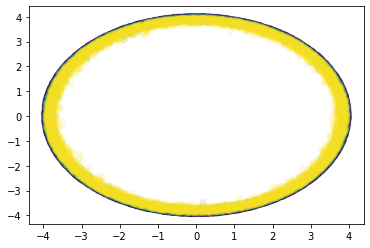

In [167]:
if N_DENSE > 1:
    plt.scatter(components[:,0], components[:,1], c=pd.to_numeric(df_conf["T"]), alpha=0.1)

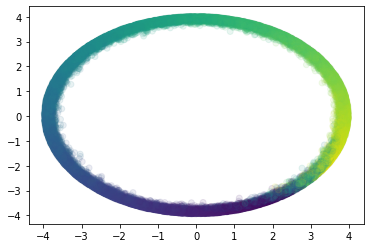

In [172]:
if N_DENSE > 1:
    plt.scatter(components[:,0], components[:,1], c=pd.to_numeric(df_conf["M"]), alpha=0.1)

# Dense AE

In [180]:
simp_ae = tf.keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(L*L*2,)),
        keras.layers.Dense(N_DENSE, use_bias=False, name='latent_space'),
        keras.layers.Dense(L*L*2),
    ]
)

print(simp_ae.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latent_space (Dense)        (None, 2)                 64        
                                                                 
 dense_2 (Dense)             (None, 32)                96        
                                                                 
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________
None


In [181]:
tb_callback = keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=0,  
    write_graph=True,
    write_images=True
)

simp_ae.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [182]:
simp_ae.fit(
    batch_size=16,
    x=train.to_numpy(),
    y=train.to_numpy(),
    epochs=20,
    callbacks=[tb_callback]
)

Train on 24000 samples
Epoch 1/20


2022-08-24 08:47:04.156302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 08:47:04.156558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 08:47:04.156738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 08:47:04.156950: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 08:47:04.157129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

   16/24000 [..............................] - ETA: 9:05 - loss: 0.5947 - mae: 0.6710

2022-08-24 08:47:04.639141: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-08-24 08:47:04.639159: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-08-24 08:47:04.639677: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-08-24 08:47:04.640357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2022-08-24 08:47:04.805353: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-24 08:47:04.805901: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed


 2304/24000 [=>............................] - ETA: 8s - loss: 0.4672 - mae: 0.5971 

2022-08-24 08:47:04.973744: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 51 callback api events and 50 activity events. 
2022-08-24 08:47:04.977442: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-08-24 08:47:04.982091: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /home/owen//logs/fit/20220822-085531/plugins/profile/2022_08_24_08_47_04

2022-08-24 08:47:04.983348: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /home/owen//logs/fit/20220822-085531/plugins/profile/2022_08_24_08_47_04/owen-PRIME-Z390-A.trace.json.gz
2022-08-24 08:47:04.992798: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /home/owen//logs/fit/20220822-085531/plugins/profile/2022_08_24_08_47_04

2022-08-24 08:47:04.993417: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_

24000/24000 [==============================] - 2s 96us/sample - loss: 0.1550 - mae: 0.2758
Epoch 2/20
24000/24000 [==============================] - 1s 50us/sample - loss: 0.0285 - mae: 0.1215
Epoch 3/20
24000/24000 [==============================] - 1s 42us/sample - loss: 0.0278 - mae: 0.1193
Epoch 4/20
24000/24000 [==============================] - 1s 44us/sample - loss: 0.0276 - mae: 0.1189
Epoch 5/20
24000/24000 [==============================] - 1s 43us/sample - loss: 0.0276 - mae: 0.1188
Epoch 6/20
24000/24000 [==============================] - 1s 43us/sample - loss: 0.0276 - mae: 0.1188
Epoch 7/20
24000/24000 [==============================] - 1s 43us/sample - loss: 0.0276 - mae: 0.1188
Epoch 8/20
24000/24000 [==============================] - 1s 43us/sample - loss: 0.0276 - mae: 0.1188
Epoch 9/20
24000/24000 [==============================] - 1s 43us/sample - loss: 0.0276 - mae: 0.1188
Epoch 10/20
24000/24000 [==============================] - 1s 42us/sample - loss: 0.0276 - ma

In [183]:
mid_layer = simp_ae.get_layer('latent_space')

In [184]:
mid_layer.get_weights()[0].shape

(32, 2)

In [185]:
extractor = keras.Model(inputs=simp_ae.inputs,
                        outputs=[layer.output for layer in simp_ae.layers])

In [187]:
features = extractor(df.to_numpy())

In [189]:
features

[<tf.Tensor 'model/latent_space/MatMul:0' shape=(30000, 2) dtype=float32>,
 <tf.Tensor 'model/dense_2/BiasAdd:0' shape=(30000, 32) dtype=float32>]

In [201]:
features[0][:,0].asnumpy()

AttributeError: 'Tensor' object has no attribute 'asnumpy'

NotImplementedError: Cannot convert a symbolic tf.Tensor (strided_slice_4:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.

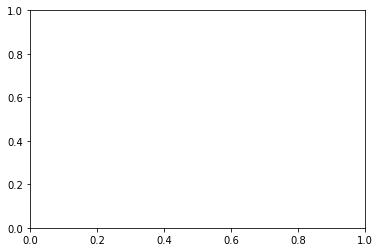

In [193]:
plt.scatter(features[0][:,0], features[0][:,1] )#, c=df_conf["T"])

# Dense VAE

In [ ]:
vae = DenseVariationalAutoencoder(
    input_dim=(L*L,),
    encoder_layer_sizes=[2],
    decoder_layer_sizes=[2, L*L],
    z_dim=N_DENSE,
    non_linear_activation_bool=NON_LINEAR_ACTIVATION_BOOL
)